In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data


def oneDim2threeDim(line, xs, ys, zs):
    resx = []
    for i in range(xs):
        resy = []
        for j in range(ys):
            resz = []
            for k in range(zs):
                resz.append(line.pop(0))
            resy.append(resz)
        resx.append(resy)
    return np.array(resx)[1:-1,1:-1,1:-1]

def read_data(data_dir: str, prefix: str, xs: int, ys: int, zs: int):
    coords_file = prefix + 'coords.txt'
    u_analyt = prefix + 'uAnalytical.txt'
    u_approx = prefix + 'uLastStep.txt'

    data = {
        'golden': {},
        'approx': {}
    }
    coords = [tuple(line.strip().split(' ')) for line in open(coords_file).readlines()]
    golden_blocks = [oneDim2threeDim(line.strip().split(' '), xs, ys, zs) for line in tqdm(open(u_analyt).readlines(), total=128)]
    approx_blocks = [oneDim2threeDim(line.strip().split(' '), xs, ys, zs) for line in tqdm(open(u_approx).readlines(), total=128)]
    for coord, golden, approx in tqdm(zip(coords, golden_blocks, approx_blocks), total=128):
        data['golden'][coord] = golden
        data['approx'][coord] = approx

    return data

In [3]:
data = read_data('.', '256_20_1_1_1_0.001_66_66_34_deltaxyz_0.00389105_deltat_5.26316e-05_', 66, 66, 34)

100%|██████████| 128/128 [00:00<00:00, 374386.97it/s]


In [4]:
xxxg = []
xxxa = []
for x in range(4):
    yyyg = []
    yyya = []
    for y in range(4):
        zzzg = []
        zzza = []
        for z in range(8):
            key = (str(x), str(y), str(z))
            zzzg.append(data['golden'][key])
            zzza.append(data['approx'][key])
        yyyg.append(zzzg)
        yyya.append(zzza)
    xxxg.append(yyyg)
    xxxa.append(yyya)

resg = np.block(xxxg).astype(float)
resa = np.block(xxxa).astype(float)
err = abs(resg - resa)

In [61]:
print(err.max())

1.0000000000287557e-06


In [68]:
delta_x = float('0.00389105')
delta_y = float('0.00389105')
delta_z = float('0.00389105')
delta_t = float('5.26316e-05')
t = delta_t * 19
x, y, z = np.unravel_index(err.argmax(), err.shape)
x += 1
y += 1
z += 1
print(f'max error at x: {x * delta_x}, y: {y * delta_y}, z: {z * delta_z}, t: {t}')
x, y, z = np.unravel_index(err.argmax(), err.shape)
print(abs(resg[x, y, z] - resa[x, y, z]))
print(x, y, z)

max error at x: 0.12062255, y: 0.37743185, z: 0.46303495, t: 0.0010000004
1.0000000000287557e-06
30 96 118


In [27]:
np.save('max_err_oYZ_at_x_0.12062255_uAnalit', resg[x,:,:])
np.save('max_err_oYZ_at_x_0.12062255_uApprox', resa[x,:,:])
np.save('max_err_oXZ_at_y_0.37743185_uAnalit', resg[:,y,:])
np.save('max_err_oXZ_at_y_0.37743185_uApprox', resa[:,y,:])
np.save('max_err_oXY_at_z_0.46303495_uAnalit', resg[:,:,z])
np.save('max_err_oXY_at_z_0.46303495_uApprox', resa[:,:,z])

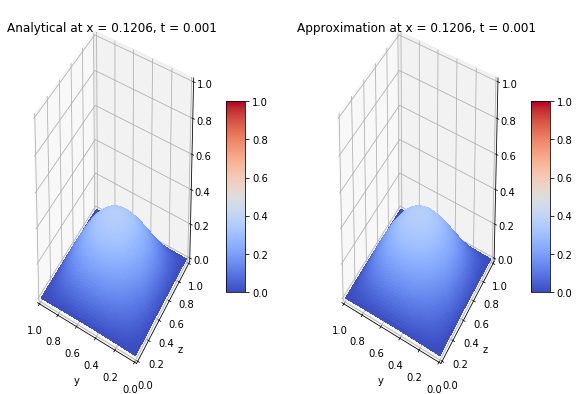

In [89]:
X = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
Y = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
X, Y = np.meshgrid(X, Y)

x_rounded = round(x * delta_x + delta_x, 4)
t_rounded = round(t, 4)

fig = plt.figure(figsize=(10, 7))

Z = resg[x,:,:]
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1.0)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Analytical at x = {x_rounded}, t = {t_rounded}')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)

Z = resa[x,:,:]
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1.0)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Approximation at x = {x_rounded}, t = {t_rounded}')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.savefig(f'atX{x_rounded}.png', dpi=420, bbox_inches='tight')
plt.show()

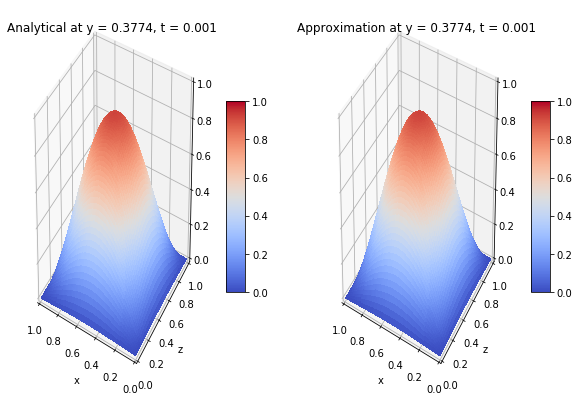

In [90]:
X = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
Y = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
X, Y = np.meshgrid(X, Y)

y_rounded = round(y * delta_y + delta_y, 4)

fig = plt.figure(figsize=(10, 7))

Z = resg[:,y,:]
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1.0)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Analytical at y = {y_rounded}, t = {t_rounded}')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)

Z = resa[:,y,:]
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1.0)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Approximation at y = {y_rounded}, t = {t_rounded}')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.savefig(f'atY{y_rounded}.png', dpi=420, bbox_inches='tight')
plt.show()

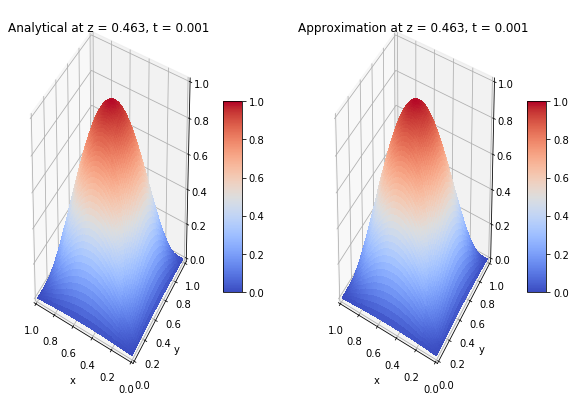

In [91]:
X = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
Y = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
X, Y = np.meshgrid(X, Y)

z_rounded = round(z * delta_z + delta_z, 4)

fig = plt.figure(figsize=(10, 7))

Z = resg[:,:,z]
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1.0)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Analytical at z = {z_rounded}, t = {t_rounded}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)

Z = resa[:,:,z]
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1.0)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Approximation at z = {z_rounded}, t = {t_rounded}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.savefig(f'atZ{z_rounded}.png', dpi=420, bbox_inches='tight')
plt.show()

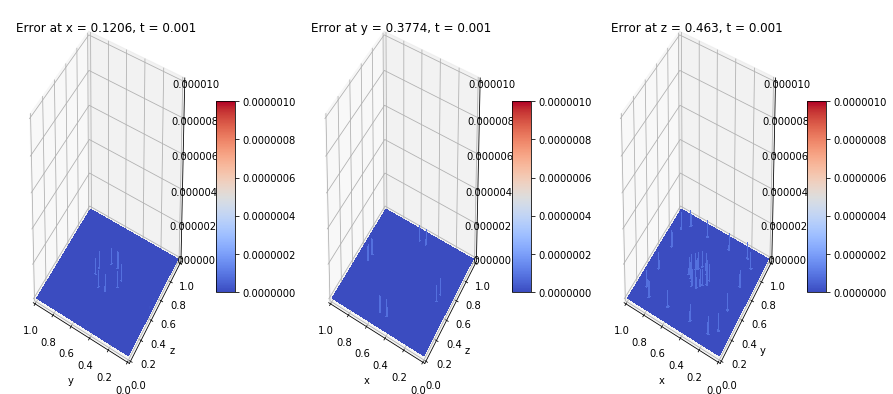

In [92]:
X = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
Y = np.arange(delta_x, (256 + 1) * delta_x, delta_x)
X, Y = np.meshgrid(X, Y)

z_rounded = round(z * delta_z + delta_z, 4)

fig = plt.figure(figsize=(15, 7))

Z = err[x,:,:]
ax = fig.add_subplot(1, 3, 1, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1e-6,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1e-5)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Error at x = {x_rounded}, t = {t_rounded}')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)

Z = err[:,y,:]
ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1e-6,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1e-5)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Error at y = {y_rounded}, t = {t_rounded}')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)

Z = err[:,:,z]
ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, vmin=0, vmax=1e-6,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_zlim(0, 1e-5)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_title(f'Error at z = {z_rounded}, t = {t_rounded}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.invert_xaxis()
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.savefig(f'err_atX{x_rounded}atY{y_rounded}atZ{z_rounded}.png', dpi=420, bbox_inches='tight')
plt.show()

In [9]:
from collections import defaultdict
from glob import glob
import pandas as pd
def get_experiments_results(experiments_dir: str):
    files = glob(f'{experiments_dir}/prog_*.txt')
    data = defaultdict(list)
    for file in files:
        L = float(file.split('_L_')[1].split('_')[0])
        numprocs = int(file.split('_npr_')[1].split('_')[0])
        numpoints = int(file.split('_npt_')[1].split('_')[0])
        numsteps = int(file.split('_nsteps_')[1].split('_')[0])
        numthreads = None if '_nt_' not in file else int(file.split('_nt_')[1].split('_')[0])
        T = float(file.split('_LT_')[1][:-4])
        t = None
        err = 0
        for line in open(file).readlines():
            if line.lstrip().startswith('number of points in grid changed from'):
                numpoints = int(line.rstrip().split(' to ')[1])
            if line.lstrip().startswith('elapsed time:'):
                t = float(line.strip().split(' ')[2])
            if line.lstrip().startswith('max error at timestep 19 is'):
                err = float(line.lstrip()[len('max error at timestep 19 is '):].strip())
            
        data['numpoints'].append(numpoints)
        data['numprocs'].append(numprocs)
        data['numsteps'].append(numsteps)
        data['numthreads'].append(numthreads)
        data['Lxyz'].append(L)
        data['T'].append(T)
        data['time'].append(t)
        data['err'].append(err)
    return pd.DataFrame(data)

In [52]:
# bluegene_df = get_experiments_results('bluegene')
# bluegene_df = bluegene_df.drop(['T', 'numsteps'], axis=1)
# bluegene_df = bluegene_df[bluegene_df.numthreads == 1].reset_index(drop=True)
# bluegene_df = bluegene_df.drop(['numthreads'], axis=1)
# bluegene_df = bluegene_df[bluegene_df.Lxyz != 1]
# bluegene_df = bluegene_df[bluegene_df.numthreads == 4]
polus_df = get_experiments_results('polus')
polus_df = polus_df.drop(['T', 'numsteps', 'numthreads'], axis=1)
polus_df = polus_df[polus_df.Lxyz != 1]

In [53]:
polus_df.sort_values(by=['numpoints', 'numprocs'])

,numpoints,numprocs,Lxyz,time,err
9,130,10,3.141593,23.7504,7.187080e-11
13,130,20,3.141593,26.1578,7.187080e-11
11,130,40,3.141593,44.4405,7.187080e-11
4,260,10,3.141593,96.2513,1.810670e-11
0,260,20,3.141593,62.5569,1.810670e-11
5,260,40,3.141593,68.4060,1.810670e-11
14,520,10,3.141593,545.4230,4.547920e-12
10,520,20,3.141593,340.9890,4.547920e-12
12,520,40,3.141593,208.4910,4.547920e-12
